# Conexión con la base de datos

In [1]:
import os
import pandas as pd
# from pandas.io import sql as psql
import snowflake.connector
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DF = pd.DataFrame
ColName = str
url = 'pm09030.east-us-2.azure.snowflakecomputing.com'
class Snowflake:
    def __init__(self, database='IMPORTACIONES', db_schema='PUBLIC') -> None:
        self.user = 'proyect4'
        self.password = 'Proyecto4*'
        self.account = 'zq59521.east-us-2.azure'
        self.warehouse = 'COMPUTE_WH'
        self.role = 'ACCOUNTADMIN'
        engine = snowflake.connector.connect(
            account=self.account,
            user=self.user,
            password=self.password,
            database=database,
            schema=db_schema,
            warehouse=self.warehouse,
            role=self.role,
        )
        try:
            self.connection = engine
        except Exception as err:
            print("I am unable to connect to the database, {}".format(err))
            raise err

 

    def read_sql(self, sql: str, params=None) -> DF:
        if params is None:
            params = {}
        cs = self.connection.cursor()
        try:
            cs.execute(sql.format(**params))
            self.data = cs.fetch_pandas_all()
        finally:
            cs.close()
        return self.data
    def execute_sp_function(self, function_name, params=[]):
        connection = self.connection
        try:
            cursor = connection.cursor()
            cursor.execute(function_name, params)
            cursor.close()
            connection.commit()
            connection.close()
        except:
            connection.close()
            raise
    def execute_statement(self, sql_statement):
        """
        Executes non result returning statement
        :param sql_statement: sql to execute
        :return: void
        """
        connection = self.connection
        try:
            with connection.cursor() as cursor:
                cursor.execute(sql_statement)
        except Exception as e:
            connection.close()
            raise Exception(str(e))
    def set_session(self, tag):
        """
        Set the query tag in the current session
        """
        query_tag = f'ALTER SESSION SET QUERY_TAG = "{tag}"'
        self.execute_statement(query_tag)
    def insert_dataframe_bulk(self, df_to_insert, dest_table, mode, db_schema, flag=False):
        """
        function to save dataframes to tables using snowflake copy clause with parquet files
        this is a slightly modified version of snowflake.connector.pandas with the to_parquet date truncating issue solved
        :param df_to_insert: dataframe to insert
        :param dest_table: name of the table
        :param mode: append,fail or replace
        :param db_schema: schema of the destination table
        :return: None
        """
        if len(df_to_insert) == 0:
            return
        connection = self.connection
        compression = 'gzip'
        compression_map = {
            'gzip': 'auto',
            'snappy': 'snappy'
        }
        # on_error = 'abort_statement'
        stage_name = dest_table.upper()
        path = f'/tmp/{dest_table}.parquet.{compression}'
        if mode == 'replace':
            if flag:
                self.execute_statement(
                    f'drop table if exists {db_schema}.{stage_name}')
                self.execute_statement(pd.io.sql.get_schema(
                    df_to_insert, stage_name).replace('"', ''))
            else:
                """
                ALERT: 2022-06-14
                This function is deprecated because pandas.DataFrame.to_sql use a sqlAlchemy connection
                Always set the flag argument True
                """
                df_to_insert.head(0).to_sql(dest_table.lower(), con=self.connection, index=False, schema=db_schema,
                                            if_exists=mode)
        with connection.cursor() as cursor:
            try:
                # create stage
                try:
                    create_stage_sql = (
                        'create stage {db_schema}.{stage_name}').format(stage_name=stage_name, db_schema=db_schema)
                    cursor.execute(create_stage_sql)
                    connection.commit()
                except Exception as pe:
                    if pe.msg.endswith('already exists.'):
                        pass
                # saves parquet locally
                # using fastparquet because in auto and pyarrow engines datetimes are processed wrong
                # when using auto (default) engine, use these parameters to get the right datetimes in tables:
                # allow_truncated_timestamps=True, use_deprecated_int96_timestamps=True
                df_to_insert.to_parquet(path, engine='auto',  compression=compression, index=False,
                                        allow_truncated_timestamps=True, use_deprecated_int96_timestamps=True)
                # takes local parquet to snowflake stage area .4 parallel processes to load (default)
                upload_sql = ('PUT file://{path} @%{stage_name} PARALLEL={parallel}').format(
                    path=path,
                    stage_name=stage_name,
                    parallel=4
                )
                cursor.execute(upload_sql)
                connection.commit()
                # copy from stage to table
                copy_into_sql = 'COPY INTO {stage_name} MATCH_BY_COLUMN_NAME=CASE_INSENSITIVE ' \
                    'PURGE=TRUE FILE_FORMAT=(TYPE=PARQUET COMPRESSION={compression})'.format(
                        stage_name=stage_name,
                        compression=compression_map[compression])
                cursor.execute(copy_into_sql, _is_internal=True)
                connection.commit()
                os.remove(path)
                #connection.close()
            except Exception as e:
                connection.close()
                raise Exception(e)

In [3]:
db_obj = Snowflake()

## Carga y transformación de datos

In [83]:
df = db_obj.read_sql("SELECT FECHA_PRESENTACION, count(*) as NUM FROM PUBLIC.IMPORTS WHERE LEFT(SUBPARTIDA_ARANCELARIA,2)='82' GROUP BY FECHA_PRESENTACION")

In [84]:
df['FECHA_PRESENTACION'] = pd.to_datetime(df['FECHA_PRESENTACION'], format='%Y%m%d')
df = df.sort_values(by='FECHA_PRESENTACION', ascending=True).set_index("FECHA_PRESENTACION")

In [85]:
df

,NUM
FECHA_PRESENTACION,
2021-01-01,3
2021-01-02,16
2021-01-04,164
2021-01-05,250
2021-01-06,254
...,...
2023-06-26,323
2023-06-27,254
2023-06-28,315


In [86]:
df.shape

(891, 1)

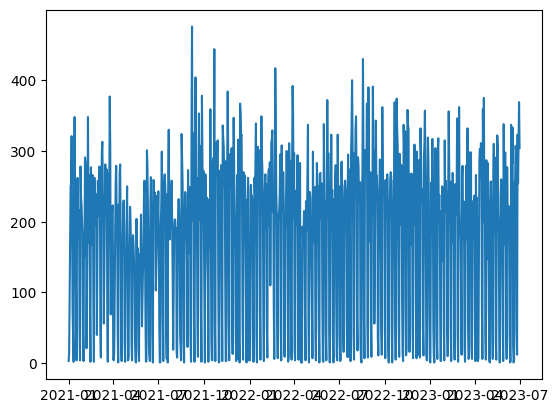

In [87]:
# plt.figure(figsize=(20,4))
#df.plot.line(x='FECHA_PRESENTACION',y='NUM',figsize=(20,6))
plt.plot(df)
# plt.ylim(0,100000)
plt.show()

# Modelado Serie de Tiempo

In [88]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [89]:
def exponential_smoothing(series,alpha):
    result = [series[0]] # first value is same as series
    for n in range(1,len(series)):
        result.append(alpha*series[n]+(1-alpha)*result[n-1])
    return result

In [90]:
def plot_exponential_smoothing(series, alphas):
   plt.figure(figsize=(10,5))
   plt.plot(series.values, 'c', label = "Actual")
   for alpha in alphas:
        plt.plot(exponential_smoothing(series,alpha), label="Alpha {}".format(alpha))
   plt.legend(loc='best')
   plt.axis('tight')
   plt.title("Exponential Smoothing")
   plt.grid(True);

In [94]:
a = [df[0]]

KeyError: 0

KeyError: 0

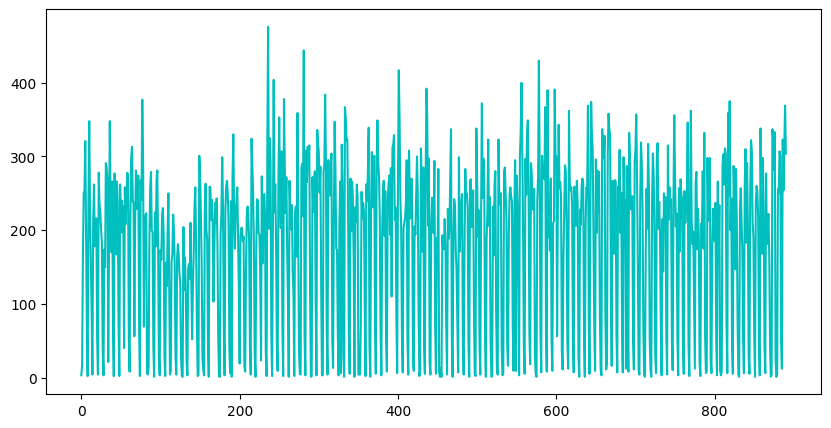

In [91]:
plot_exponential_smoothing(df,[0.05,0.3])